In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Rappel du sujet

- 15 actifs min et 40 max
- chaque actif ne doit pas etre superieux a 10% du portefeuille

# Manager API

In [3]:

class RESTManager:
    HOST_NAME = "dolphin.jump-technology.com"
    PORT = "8443"

    URL = "https://" + HOST_NAME + ":" + PORT + "/api/v1/"

    USERNAME_USER1 = "EPITA_GROUPE8"
    PASSWORD_USER1 = "AgLyQx64Jw6pAkW9"

    auth = (USERNAME_USER1, PASSWORD_USER1)


    def get(self, path):
        return requests.get(self.URL+path, auth=self.auth, verify=False).text
    
    def put(self, path, data):
        return requests.put(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def post(self, path, data):
        return requests.post(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def get_asset(self):
        dt_text = self.get("asset?columns=ASSET_DATABASE_ID&columns=LABEL&columns=TYPE&columns=LAST_CLOSE_VALUE_IN_CURR&columns=CURRENCY&date=2016-06-01")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        return df
    
    def get_asset_id(self, uid):
        dt_text = self.get(f"asset/{uid}")
        dt = json.loads(dt_text)
        df={}
        for key in dt:
            df[key] = dt[key]["value"]
        #df = pd.DataFrame(df)
        return df
    
    def get_asset_id_quote(self, uid):
        dt_text = self.get(f"asset/{uid}/quote")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #l = ["ask" ,"asset" ,"bid" ,"close" ,"feed_source" ,"gross" ,"high" ,"low","nav" ,"open", "pl" ,"real_close_price" ,"return" ,"volume"]
        l = ["return","nav"]
        for elt in l:
            df[elt] = df[elt].str.replace(',', '.').astype(float)
        return df
    
    def get_ratio(self):
        self.get("ratio")
    
    def sharpe(self, df, taux_sans_risque, periode=30):
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=periode).std() * np.sqrt(periode)
        sharpe = (df["return"] - taux_sans_risque["1 mois"])/df["Volatility"]
        return sharpe
    
    def get_portfolio(self):
        resp = self.get("portfolio/1827/dyn_amount_compo")
        return resp

    def push(self, data):
        return self.put("portfolio/1827/dyn_amount_compo", data)
    
    def get_ratios(self, ref=False):
        data = {
            "ratio": [9, 12, 10],
            "asset": [1827, 2201],
            "start_date": "2016-06-01",
            "end_date": "2020-09-30",
            "frequency": "daily"
        }
        return self.post("ratio/invoke", json.dumps(data)).text
    
    def change_currency(self, c_in, c_out):
        url = f"currency/rate/{c_in}/to/{c_out}?date=2016-06-01"
        js = json.loads(self.get(url))["rate"]["value"].replace(",", ".")
        return float(js)
        

req = RESTManager()

In [4]:
df_asset = req.get_asset()
df_asset

,ASSET_DATABASE_ID,CURRENCY,LABEL,LAST_CLOSE_VALUE_IN_CURR,TYPE
0,1845,EUR,1&1 DRILLISCH AG,"36,851 EUR",STOCK
1,1846,EUR,1000MERCIS,"40,9 EUR",STOCK
2,2122,EUR,1818-VEGA EUR CO,"39,37 EUR",FUND
3,2123,EUR,29 HAUSSMANN CROISSANCE EUROPE D,"1670,65 EUR",FUND
4,2124,EUR,29 HAUSSMANN EQUILIBRE,NaN,FUND
5,1428,EUR,AAA - ACTIONS AGRO ALIM.I FCP,NaN,FUND
6,1847,EUR,AALBERTS INDS,"31,7 EUR",STOCK
7,1848,EUR,AAREAL BANK AG,"32,81 EUR",STOCK
8,1849,EUR,ABC ARBITRAGE,"6,73 EUR",STOCK
9,2154,USD,ABERDEEN CHINA EQUITY A2,"20,9896 USD",FUND


# Optimisation de portefeuille

In [5]:
def sharpe(w,mat_return):
    mat_cov = np.cov(mat_return)# * mat_return.shape[1]


    if w.ndim != 1:
        variance = []
        for i in range(w.shape[0]):
            variance.append(w[i] @ mat_cov @ w[i].T)
    else:
        variance = w @ mat_cov @ w.T
        
    variance = np.array(variance)
    std = np.sqrt(variance)
    average_rend = mat_return.mean(axis=1)
    
    return (variance, std, average_rend@w.T)


# rendement & volatilité

Commençons par calculer la volatilité et le rendement de chaque actif pour pouvoir etablir un classement.

## 1) Récuperation des rendements

In [343]:
list_id = df_asset["ASSET_DATABASE_ID"].values
l_id = []

#Pour avoir l'index
a = req.get_asset_id_quote(list_id[0])[["return"]]
list_return = pd.DataFrame(index=a.index)
list_nav = pd.DataFrame(index=a.index)


for elt in list_id:
    if elt != "1827" and elt != "1867":
        try:
            df_tmp = req.get_asset_id_quote(elt)
            list_return[elt] = df_tmp["return"]
            list_nav[elt] = df_tmp["nav"]
            l_id.append(elt)
        except:
            pass
l_id = np.array(l_id)
list_nav = list_nav.fillna(method='ffill')

In [344]:
print(l_id.shape)
print(list_return.shape)

(471,)
(1898, 471)


on veut le rendement sur 2016-06-01 jusqu'a 2020-09-30

In [345]:
import datetime as dt
start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
end = dt.datetime.strptime('2020-09-30', '%Y-%m-%d')
sdf = (list_return.index > start) & (list_return.index < end)

l_return = list_return.loc[sdf]
l_return = l_return.fillna(0)

## 2) Classement

In [346]:
rend_l = l_return.values.mean(axis=0)
std_l = l_return.values.std(axis=0)
rend_l.shape

(471,)

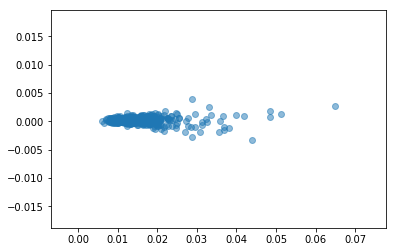

In [347]:
plt.scatter(std_l,rend_l, alpha=0.5)

Lors du classement on va favoriser les rendements a la volatilité

In [348]:
sort_rend = np.argsort(rend_l)
sort_std = np.argsort(std_l)

#classement
classement = np.zeros_like(sort_rend)
for i in range(len(sort_rend)):
    classement[sort_rend[i]] += i*30
    classement[sort_std[len(sort_rend)-1-i]] += i

## 3) Methode Naive (n=2)

Notre premiere approche est une methode dit "Brute force".  
En effet, nous allons essayer toute les possibilités, pour a la fin recupérer celle avec
la volatilité la plus faible.

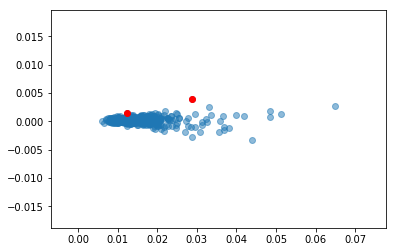

In [349]:
# on récupere les Deux meilleur
res = np.argsort(classement)[-2:]

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

rend: -0.0004465991983778891 & volatilité: 0.01247222437089075 -> poid: [0.36363636 0.63636364]


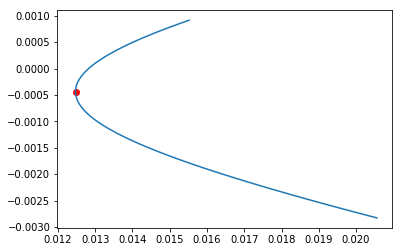

In [13]:
#On créé une matrice avec les rendements de chaque actif en column
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

#On va faire une list de tout les w possible
w = np.linspace(0, 1, num=100)
W = np.array([w, 1-w]).T

variance, std, rend = sharpe(W, mat_return)

#On récupere le minimum de volatilité
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)
plt.scatter(std[minimum], rend[minimum], c="red")

## Methode Naive à 3 actifs (n=3) 

[112 298 199]


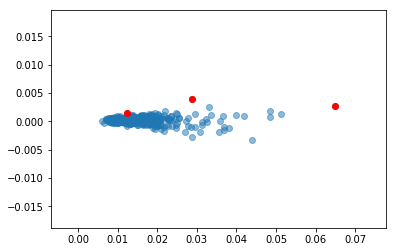

In [14]:
import itertools

w = np.linspace(0, 1, num=100)

n_w = np.array(list(itertools.permutations(w, 3)))

n_w = n_w[np.sum(n_w,axis=1) == 1]

res = np.argsort(classement)[-3:]
print(res)

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

In [15]:
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

variance, std, rend = sharpe(n_w, mat_return)

rend: 0.003307973502525167 & volatilité: 0.010300211492216297 -> poid: [0.29292929 0.26262626 0.44444444]


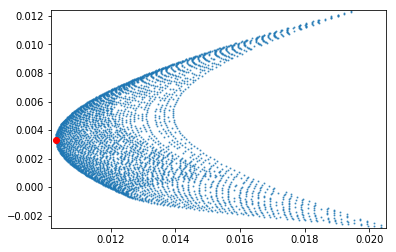

In [16]:
minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {n_w[minimum]}")

plt.margins(x=0, y=-0.01)
plt.scatter(std,rend,s=1, alpha=0.7)
plt.scatter(std[minimum], rend[minimum], c="red")

# Optimization (minimal var) [avec Resolution analytique]

In [17]:
res = np.argsort(classement)[-2:]
mat_return = np.array(l_return.values[res])


> https://www.ephiquant.com/optimisation-de-portefeuille-modele-mean-variance-de-markowitz/

on cherche a optimiser le programme quadratique suivant

$$ 
 \left\{
    \begin{array}{ll}
       Min \ \sigma^2_p(w) = w^T\sigma w \\
       w^Tu = 1
    \end{array}
\right.$$

on va utiliser la méthode du multiplicateur de Lagrange:

$$
\mathcal{L}(\omega,\lambda) = \omega^\top \sigma \omega - \lambda(\omega^\top u-1)
$$

> où $\lambda$ est le multiplicateur de Lagrange

Nous allons ensuite calculer les dérivées partielles que nous allons spécifier égales à 0 : 

$$
\begin{cases} \frac{\partial\mathcal{L}}{\omega}= 2\sigma\omega-\lambda u=0 \quad \text{(a)}\\  \frac{\partial\mathcal{L}}{\partial\lambda}=\omega^\top u-1=0 \quad\quad\text{(b)}\end{cases}
$$

Nous allons d’abord tirer $\omega$ dans l’équation (a), après quoi nous allons le remplacer dans l’équation (b) par son expression: 

$$
\begin{split} \text{(a)} \quad 2\sigma\omega-\lambda u=0\quad  \implies \omega &= \frac{1}{2}\lambda\sigma^{-1}u \\ \text{(b)} \quad \omega^\top u-1=0 \implies \omega^\top u &= 1 \\ \frac{1}{2}\lambda u^\top\sigma^{-1}u &=1 \\  \lambda &= \frac{2}{u^\top\sigma^{-1}u} \end{split}
$$

Nous allons mettre cette dernière expression de $\lambda$ dans l’expression de $\omega$. Cela donnera ceci : 

$$
\begin{equation*}\omega=\frac{1}{2} \bigg(\frac{2}{u^{\top}\sigma^{-1}u} \bigg) \sigma^{-1}u \implies \omega=\frac{\sigma^{-1}u}{u^\top\sigma^{-1}u} \end{equation*}
$$

In [18]:
# u = [1, ..., 1]

In [19]:
r = rend_l[res]
u = np.ones(r.shape[0])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
w

array([0.36105675, 0.63894325])

rend: -0.0004465991983778891 & volatilité: 0.01247222437089075 -> poid: [0.36363636 0.63636364]
rend: -0.0004369427732414565 & volatilité: 0.01247204980519934 -> poid: [0.36105675 0.63894325]


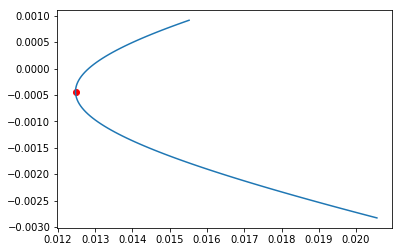

In [20]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T

variance, std, rend = sharpe(W, mat_return)
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)

variance, std, rend = sharpe(w, mat_return)
plt.scatter(std, rend, c="red")
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

## resolution analytique avec les 15 meilleurs actifs

In [21]:
res = np.argsort(classement)[-15:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.11409408, 0.04122997, 0.08851583, 0.06739106, 0.04124986,
       0.11305451, 0.12803129, 0.04863073, 0.01108649, 0.05458294,
       0.03439904, 0.09094654, 0.04951367, 0.0183365 , 0.09893749])

In [22]:
variance, std, rend = sharpe(w, mat_return)
print(f"rend: {rend} & volatilité: {std} \n -> poid: {w}")

rend: 0.0026683773943286834 & volatilité: 0.004393268101614537 
 -> poid: [0.11409408 0.04122997 0.08851583 0.06739106 0.04124986 0.11305451
 0.12803129 0.04863073 0.01108649 0.05458294 0.03439904 0.09094654
 0.04951367 0.0183365  0.09893749]


## Benchmark

Regardons l'influence du nombre d'actif sur le rendement et la volatilité.

[2] rend: -0.0004369427732414565 & volatilité: 0.01247204980519934
[3] rend: 0.003367652777146972 & volatilité: 0.01029928910267818
[4] rend: 0.0035259702482595637 & volatilité: 0.008324506342767189
[5] rend: 0.003051527610881727 & volatilité: 0.008085443144501386
[6] rend: 0.0035378697852437575 & volatilité: 0.007212088834941763
[7] rend: 0.0036305010163024186 & volatilité: 0.006819057627645176
[8] rend: 0.004124423187347633 & volatilité: 0.006187060628671193
[9] rend: 0.0037238858405736885 & volatilité: 0.005644612595226033
[10] rend: 0.0032948769822232784 & volatilité: 0.005282003362432458
[11] rend: 0.003634499730351129 & volatilité: 0.0051917672983101655
[12] rend: 0.0031529611851744536 & volatilité: 0.004975765608848374
[13] rend: 0.0032955083359279555 & volatilité: 0.004808176275335639
[14] rend: 0.003124527561786953 & volatilité: 0.0047468057911323955
[15] rend: 0.0026683773943286834 & volatilité: 0.004393268101614537
[16] rend: 0.0023886697873949534 & volatilité: 0.00398826619

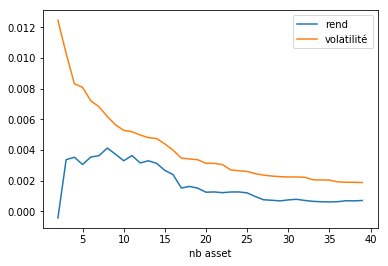

In [23]:
hist = []
for i in range(2,40,1):
    res = np.argsort(classement)[-i:]
    r = rend_l[res]
    u = np.ones(r.shape[0])
    mat_return = np.array(l_return.values[res])

    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 

    w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
    variance, std, rend = sharpe(w, mat_return)
    print(f"[{i}] rend: {rend} & volatilité: {std}")
    hist.append([rend, std])

hist = np.array(hist)

plt.plot(range(2,40,1),hist[:,0], label="rend")
plt.plot(range(2,40,1),hist[:,1], label="volatilité")
plt.xlabel("nb asset")
plt.legend()

## Optimisation avec rendement fixé

In [24]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

$$
\begin{equation*}\omega=E\mu_0+F\end{equation*}
$$

avec:

$$
E=\frac{1}{D}\sigma^{-1}(C\mu-Au)\quad \text{et} \quad F=\frac{1}{D}\sigma^{-1}(-A\mu+Bu)
$$


Nous allons définir 
- $A=u^\top\sigma^{-1}\mu=\mu^\top\sigma^{-1}u$ 
- $B=\mu^\top\sigma^{-1}\mu$ 
- $C=u^\top\sigma^{-1}u$
- $D=BC-A^2$

In [25]:
A = u.T @ sigma_inv @ r 
B = r.T @ sigma_inv @ r
C = u.T @ sigma_inv @ u
D = B*C - (A**2)

In [26]:
E = (1/D) * sigma_inv @ (C*r - A*u)
F = (1/D) * sigma_inv @ (-A*r + B*u)

w = E* 0.004 + F
w

array([0.99733108, 0.00266892])

In [27]:
variance, std, rend = sharpe(w, mat_return)
print(f"[{i}] rend: {rend} & volatilité: {std}")

[39] rend: -0.002818750582300833 & volatilité: 0.02050535048138912


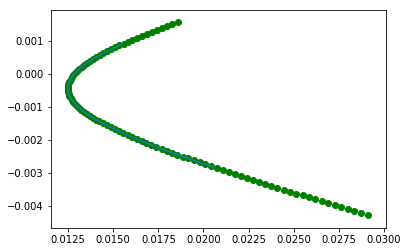

In [28]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
plt.plot(std,rend)

target_ = np.linspace(0.001, 0.005, num=100)
best = ""

for i in target_:
    w = E* i + F
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

En Rouge: rendement > risque  
En Vert : rendement < risque

## N=15

In [29]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])

In [30]:
def get_w(mat_return, u_t= 0.0017):
    r = mat_return.mean(axis=1)
    u = np.ones(r.shape[0])
    
    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 
    
    A = u.T @ sigma_inv @ r 
    B = r.T @ sigma_inv @ r
    C = u.T @ sigma_inv @ u
    D = B*C - (A**2)
    
    E = (1/D) * sigma_inv @ (C*r - A*u)
    F = (1/D) * sigma_inv @ (-A*r + B*u)

    w = E* u_t + F
    return w


w_20 = get_w(mat_return, 0.003)
print(w_20)
sharpe(w_20, mat_return)

[0.10778586 0.03592542 0.09242703 0.059778   0.05087698 0.10393058
 0.12372796 0.05545009 0.01622113 0.06122143 0.03035973 0.09290658
 0.05520379 0.01533894 0.09884648]


(array(1.94306916e-05), 0.004408025817746978, 0.0029999999999999996)

In [31]:
def checking_w(w):
    if np.sum(w<0) == 0:
        if np.sum((w >= 0.01) & (w <= 0.1)) == w.shape[0]:
            return True
    return False

checking_w(np.array([0.2, 0.05]))

False

In [351]:
sort_ = np.argsort(rend_l/std_l)
classement2 = np.zeros_like(sort_)
for i in range(len(sort_)):
    classement2[sort_[i]] += i

15 0
16 0
17 0
18 0
19 0
0.00027, 0.00027027027027027033
0.00028, 0.00028028028028028026
0.00029, 0.0002902902902902904
0.0003, 0.00030030030030030034
0.00031, 0.00031031031031031044
0.00032, 0.0003203203203203203
0.00033, 0.0003303303303303304
0.00034, 0.00034034034034034034
0.00035, 0.00035035035035035054
0.00036, 0.00036036036036036026
0.00037, 0.0003703703703703704
0.00038, 0.00038038038038038066
0.00039, 0.0003903903903903905
0.0004, 0.0004004004004004007
0.00041, 0.00041041041041041035
0.00042, 0.0004204204204204204
0.00043, 0.00043043043043043027
0.00044, 0.0004404404404404406
0.00045, 0.0004504504504504505
0.00046, 0.00046046046046046066
0.00047, 0.0004704704704704704
0.00048, 0.0004804804804804805
0.00049, 0.0004904904904904906
0.000501, 0.0005005005005005007
0.000511, 0.0005105105105105106
0.000521, 0.0005205205205205203
0.000531, 0.0005305305305305305
0.000541, 0.0005405405405405405
0.000551, 0.0005505505505505506
0.000561, 0.0005605605605605605
0.000571, 0.00057057057057057

19 1
0.0, -2.0498197323554068e-19
1e-05, 1.0010010010009834e-05
2e-05, 2.0020020020019816e-05
3e-05, 3.003003003002998e-05
4e-05, 4.004004004003987e-05
5.01e-05, 5.00500500500498e-05
6.01e-05, 6.0060060060059896e-05
7.01e-05, 7.007007007006967e-05
8.01e-05, 8.008008008007989e-05
9.01e-05, 9.009009009008993e-05
0.0001, 0.00010010010010009991
0.00011, 0.00011011011011010996
0.00012, 0.00012012012012012002
0.00013, 0.00013013013013012995
0.00014, 0.00014014014014014005
0.00015, 0.00015015015015014993
0.00016, 0.00016016016016016
0.00017, 0.00017017017017016998
0.00018, 0.00018018018018018018
0.00019, 0.00019019019019019
0.0002, 0.00020020020020019983
0.00021, 0.00021021021021021003
0.00022, 0.0002202202202202199
0.00023, 0.0002302302302302301
0.00024, 0.00024024024024024005
0.00025, 0.00025025025025025
0.00026, 0.00026026026026026007
0.00027, 0.00027027027027027033
0.00028, 0.00028028028028028015
0.00029, 0.0002902902902902901
0.0003, 0.00030030030030030034
0.00031, 0.00031031031031031
0.

19 2
20 2
21 2
22 2
0.0, 1.3552527156068805e-20
1e-05, 1.0010010010009959e-05
2e-05, 2.0020020020019904e-05
3e-05, 3.0030030030030053e-05
4e-05, 4.004004004004012e-05
5.01e-05, 5.005005005004986e-05
6.01e-05, 6.006006006006007e-05
7.01e-05, 7.007007007007009e-05
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
15 4
16 4
17 4
18 4
19 4
20 4
21 4
22 4
23 4
0.00011, 0.00011011011011011017
0.00012, 0.00012012012012012016
0.00013, 0.00013013013013013033
0.00014, 0.00014014014014014035
0.00015, 0.00015015015015015012
0.00016, 0.00016016016016016027
0.00017, 0.00017017017017017012
0.00018, 0.00018018018018018016
0.00019, 0.0001901901901901903
0.0002, 0.0002002002002002004
0.00021, 0.00021021021021021033
0.00022, 0.00022022022022022026
0.00023, 0.00023023023023023047
0.00024, 0.00024024024024024042
0.00025, 0.0002502502502502503
0.0002

23 8
0.0, 1.3552527156068805e-20
1e-05, 1.0010010010009837e-05
2e-05, 2.0020020020020047e-05
3e-05, 3.0030030030029958e-05
4e-05, 4.0040040040040154e-05
5.01e-05, 5.00500500500501e-05
6.01e-05, 6.0060060060060106e-05
7.01e-05, 7.007007007006996e-05
8.01e-05, 8.008008008007994e-05
9.01e-05, 9.009009009009004e-05
0.0001, 0.00010010010010010016
0.00011, 0.0001101101101101101
0.00012, 0.00012012012012012013
0.00013, 0.00013013013013013004
0.00014, 0.00014014014014014008
0.00015, 0.0001501501501501501
0.00016, 0.00016016016016016032
0.00017, 0.0001701701701701701
0.00018, 0.00018018018018018007
0.00019, 0.00019019019019019022
0.0002, 0.00020020020020020026
0.00021, 0.0002102102102102102
0.00022, 0.00022022022022022024
0.00023, 0.00023023023023023022
0.00024, 0.00024024024024024015
0.00025, 0.00025025025025025025
0.00026, 0.0002602602602602601
0.00027, 0.00027027027027027033
0.00028, 0.0002802802802802805
0.00029, 0.00029029029029029035
0.0003, 0.0003003003003003003
0.00031, 0.00031031031031

26 9
27 9
28 9
29 9
30 9
31 9
32 9
33 9
34 9
35 9
36 9
37 9
38 9
39 9
15 10
16 10
17 10
18 10
19 10
20 10
21 10
22 10
23 10
24 10
0.0, -1.2197274440461925e-19
1e-05, 1.0010010010009986e-05
2e-05, 2.0020020020019986e-05
3e-05, 3.0030030030029823e-05
4e-05, 4.0040040040039944e-05
5.01e-05, 5.005005005004996e-05
6.01e-05, 6.006006006005973e-05
7.01e-05, 7.007007007006996e-05
8.01e-05, 8.008008008007994e-05
9.01e-05, 9.009009009008989e-05
0.0001, 0.00010010010010009987
0.00011, 0.00011011011011011
0.00012, 0.0001201201201201199
0.00013, 0.00013013013013012998
0.00014, 0.0001401401401401399
0.00015, 0.00015015015015015004
0.00016, 0.00016016016016016016
0.00017, 0.00017017017017017
0.00018, 0.00018018018018018016
0.00019, 0.00019019019019019006
0.0002, 0.00020020020020020018
0.00021, 0.00021021021021020998
0.00022, 0.0002202202202202201
0.00023, 0.00023023023023023033
0.00024, 0.00024024024024023994
0.00025, 0.00025025025025025014
0.00026, 0.0002602602602602599
0.00027, 0.000270270270270270

24 11
25 11
26 11
27 11
28 11
29 11
30 11
31 11
32 11
33 11
34 11
35 11
36 11
37 11
38 11
39 11
15 12
16 12
17 12
18 12
19 12
20 12
21 12
22 12
23 12
24 12
25 12
26 12
27 12
28 12
29 12
30 12
31 12
32 12
33 12
34 12
35 12
36 12
37 12
38 12
39 12
15 13
16 13
17 13
18 13
0.0, 2.168404344971009e-19
1e-05, 1.0010010010010257e-05
2e-05, 2.0020020020020514e-05
3e-05, 3.0030030030030338e-05
4e-05, 4.004004004004038e-05
5.01e-05, 5.005005005005042e-05
6.01e-05, 6.006006006006046e-05
7.01e-05, 7.007007007007039e-05
8.01e-05, 8.008008008008021e-05
9.01e-05, 9.009009009009036e-05
0.0001, 0.0001001001001001004
0.00011, 0.00011011011011011033
0.00012, 0.00012012012012012037
0.00013, 0.00013013013013013042
0.00014, 0.00014014014014014035
0.00015, 0.0001501501501501506
0.00016, 0.00016016016016016054
0.00017, 0.00017017017017017047
0.00018, 0.00018018018018018062
0.00019, 0.00019019019019019066
0.0002, 0.0002002002002002006
0.00021, 0.00021021021021021063
0.00022, 0.00022022022022022045
0.00023, 0.00

21 13
0.0, 3.2526065174565133e-19
1e-05, 1.0010010010010257e-05
2e-05, 2.0020020020020297e-05
3e-05, 3.0030030030030338e-05
4e-05, 4.0040040040040595e-05
5.01e-05, 5.005005005005031e-05
6.01e-05, 6.006006006006046e-05
7.01e-05, 7.007007007007039e-05
8.01e-05, 8.008008008008054e-05
9.01e-05, 9.009009009009058e-05
0.0001, 0.00010010010010010051
0.00011, 0.00011011011011011033
0.00012, 0.00012012012012012048
0.00013, 0.0001301301301301302
0.00014, 0.00014014014014014024
0.00015, 0.0001501501501501506
0.00016, 0.00016016016016016054
0.00017, 0.00017017017017017063
0.00018, 0.0001801801801801804
0.00019, 0.00019019019019019039
0.0002, 0.00020020020020020048
0.00021, 0.00021021021021021068
0.00022, 0.00022022022022022045
0.00023, 0.00023023023023023055
0.00024, 0.00024024024024024064
0.00025, 0.0002502502502502504
0.00026, 0.0002602602602602606
0.00027, 0.0002702702702702708
0.00028, 0.0002802802802802807
0.00029, 0.0002902902902902907
0.0003, 0.00030030030030030067
0.00031, 0.00031031031031

20 14
0.0, -8.131516293641283e-20
1e-05, 1.0010010010009932e-05
2e-05, 2.0020020020020026e-05
3e-05, 3.0030030030030012e-05
4e-05, 4.004004004003992e-05
5.01e-05, 5.005005005004982e-05
6.01e-05, 6.006006006005973e-05
7.01e-05, 7.007007007006993e-05
8.01e-05, 8.008008008007985e-05
9.01e-05, 9.009009009009005e-05
0.0001, 0.00010010010010009996
0.00011, 0.00011011011011010996
0.00012, 0.00012012012012012008
0.00013, 0.0001301301301301301
0.00014, 0.00014014014014014008
0.00015, 0.00015015015015014998
0.00016, 0.00016016016016015986
0.00017, 0.00017017017017016995
0.00018, 0.00018018018018017997
0.00019, 0.00019019019019018987
0.0002, 0.0002002002002002001
0.00021, 0.00021021021021020998
0.00022, 0.0002202202202202201
0.00023, 0.0002302302302302301
0.00024, 0.00024024024024024013
0.00025, 0.0002502502502502499
0.00026, 0.00026026026026026
0.00027, 0.00027027027027027
0.00028, 0.00028028028028028026
0.00029, 0.00029029029029029025
0.0003, 0.00030030030030030023
0.00031, 0.000310310310310310

19 15
0.0, -4.298692207315574e-19
1e-05, 1.0010010010009701e-05
2e-05, 2.0020020020019725e-05
3e-05, 3.0030030030029857e-05
4e-05, 4.004004004003955e-05
5.01e-05, 5.00500500500499e-05
6.01e-05, 6.006006006005992e-05
7.01e-05, 7.007007007006973e-05
8.01e-05, 8.008008008007986e-05
9.01e-05, 9.009009009008989e-05
0.0001, 0.00010010010010009991
0.00011, 0.00011011011011010971
0.00012, 0.00012012012012011974
0.00013, 0.00013013013013012976
0.00014, 0.00014014014014014
0.00015, 0.00015015015015015004
0.00016, 0.00016016016016015983
0.00017, 0.00017017017017017006
0.00018, 0.00018018018018017978
0.00019, 0.0001901901901901899
0.0002, 0.00020020020020019994
0.00021, 0.00021021021021020973
0.00022, 0.00022022022022021986
0.00023, 0.0002302302302302299
0.00024, 0.00024024024024024002
0.00025, 0.0002502502502502498
0.00026, 0.00026026026026026007
0.00027, 0.0002702702702702701
0.00028, 0.00028028028028028
0.00029, 0.00029029029029029025
0.0003, 0.00030030030030030007
0.00031, 0.000310310310310310

19 16
20 16
21 16
22 16
23 16
24 16
25 16
26 16
27 16
28 16
29 16
30 16
31 16
32 16
33 16
34 16
35 16
36 16
37 16
38 16
39 16
15 17
16 17
0.000871, 0.0008708708708708711
0.000881, 0.0008808808808808809
0.000891, 0.0008908908908908909
0.000901, 0.000900900900900901
0.000911, 0.000910910910910911
0.000921, 0.000920920920920921
0.000931, 0.000930930930930931
0.000941, 0.0009409409409409412
0.000951, 0.000950950950950951
0.000961, 0.0009609609609609613
0.000971, 0.000970970970970971
0.000981, 0.0009809809809809811
0.000991, 0.000990990990990991
0.001, 0.001001001001001001
0.00101, 0.001011011011011011
0.00102, 0.001021021021021021
0.00103, 0.001031031031031031
0.00104, 0.0010410410410410412
0.00105, 0.001051051051051051
0.00106, 0.001061061061061061
0.00107, 0.0010710710710710712
0.00108, 0.0010810810810810813
0.00109, 0.001091091091091091
0.0011, 0.0011011011011011012
0.00111, 0.0011111111111111111
0.00112, 0.001121121121121121
0.00113, 0.0011311311311311312
0.00114, 0.0011411411411411413

16 18
0.00111, 0.0011111111111111111
0.00112, 0.0011211211211211208
0.00113, 0.0011311311311311312
0.00114, 0.0011411411411411411
0.00115, 0.001151151151151151
0.00116, 0.0011611611611611612
0.00117, 0.001171171171171171
0.00118, 0.001181181181181181
0.00119, 0.0011911911911911912
0.0012, 0.001201201201201201
0.00121, 0.001211211211211211
0.00122, 0.001221221221221221
0.00123, 0.0012312312312312314
0.00124, 0.001241241241241241
0.00125, 0.0012512512512512508
0.00126, 0.001261261261261261
0.00127, 0.001271271271271271
0.00128, 0.001281281281281281
0.00129, 0.001291291291291291
0.0013, 0.0013013013013013011
0.00131, 0.0013113113113113113
0.00132, 0.001321321321321321
0.00133, 0.0013313313313313311
0.00134, 0.0013413413413413413
0.00135, 0.0013513513513513514
0.00136, 0.0013613613613613614
0.00137, 0.0013713713713713713
0.00138, 0.0013813813813813814
0.00139, 0.0013913913913913916
0.0014, 0.0014014014014014013
0.00141, 0.0014114114114114115
0.00142, 0.0014214214214214216
0.00143, 0.001431

0.00254, 0.0025425425425425426
0.00255, 0.002552552552552552
0.00256, 0.002562562562562563
0.00257, 0.002572572572572573
0.00258, 0.002582582582582583
0.00259, 0.0025925925925925925
0.0026, 0.0026026026026026027
0.00261, 0.002612612612612613
0.00262, 0.002622622622622623
0.00263, 0.0026326326326326327
0.00264, 0.0026426426426426424
0.00265, 0.0026526526526526525
21 18
22 18
23 18
24 18
25 18
26 18
27 18
28 18
29 18
30 18
31 18
32 18
33 18
34 18
35 18
36 18
37 18
38 18
39 18
15 19
0.00192, 0.0019219219219219219
0.00193, 0.0019319319319319318
0.00194, 0.001941941941941942
0.00195, 0.0019519519519519521
0.00196, 0.0019619619619619614
0.00197, 0.001971971971971972
0.00198, 0.001981981981981982
0.00199, 0.0019919919919919914
0.002, 0.002002002002002002
0.00201, 0.0020120120120120117
0.00202, 0.002022022022022022
0.00203, 0.002032032032032032
0.00204, 0.002042042042042042
0.00205, 0.0020520520520520514
0.00206, 0.002062062062062062
0.00207, 0.002072072072072072
0.00208, 0.002082082082082082


0.00293, 0.0029329329329329337
0.00294, 0.0029429429429429434
0.00295, 0.0029529529529529535
0.00296, 0.0029629629629629637
0.00297, 0.0029729729729729734
0.00298, 0.002982982982982983
0.00299, 0.0029929929929929933
0.003, 0.0030030030030030034
0.00301, 0.0030130130130130144
0.00302, 0.0030230230230230224
21 19
22 19
23 19
24 19
25 19
0.00154, 0.0015415415415415423
0.00155, 0.0015515515515515518
0.00156, 0.001561561561561562
0.00157, 0.001571571571571572
0.00158, 0.0015815815815815818
26 19
27 19
28 19
29 19
30 19
31 19
32 19
33 19
34 19
35 19
36 19
37 19
38 19
39 19
rend: 0.0030230230230230224 & volatilité: 0.003462763425139605


array([0.0743342 , 0.03965915, 0.02445111, 0.01573476, 0.0661829 ,
       0.05180581, 0.03825727, 0.02543263, 0.09039676, 0.08365875,
       0.08579775, 0.04958844, 0.05912504, 0.01008399, 0.07182041,
       0.025043  , 0.04070595, 0.03774437, 0.04962915, 0.06054855])

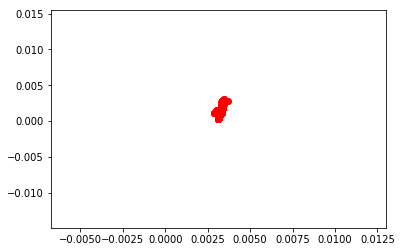

In [365]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])
target_ = np.linspace(0.000, 0.01, num=1000)
best = ""
W=np.array([])
actual_rend = 0
actual_std = 1
decal = 0
Res=[]

while decal < 20:
    for j in range(15,40):
        print(j, decal)
        if decal > 0:
            res = np.argsort(classement2)[-j-decal:-decal]
        else:
            res = np.argsort(classement2)[-j:]
        mat_return = np.array(l_return.values[res])
        for i in target_:
            w = get_w(mat_return, i)
            if checking_w(w):
                variance, std, rend = sharpe(w, mat_return)
                print(f"{i:0.3}, {rend}")
                if actual_rend/actual_std < rend/std:
                    Res=res
                    W=w
                    actual_rend= rend
                    actual_std = std
                    best = f"rend: {rend} & volatilité: {std}"
                    plt.scatter(std, rend, c="red")
    decal+=1
        
print(best)
W

## Verification

Notre porte-feuille doit respecter plusieurs criteres:

- 50% stock en prix
- check la currency
- check les lots
- 1% a 10% par actif


In [366]:
def check_type(list_id):
    #df_asset = req.get_asset()[["ASSET_DATABASE_ID", "TYPE"]]
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["TYPE"].values
    #print(np.unique(pf_type, return_counts=True))
    return pf_type
    
    
check_type(l_id[Res])

array(['STOCK', 'STOCK', 'STOCK', 'STOCK', 'ETF FUND', 'STOCK', 'INDEX',
       'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'INDEX',
       'STOCK', 'FUND', 'INDEX', 'INDEX', 'STOCK', 'FUND'], dtype=object)

In [367]:
def check_currency(list_id):
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["CURRENCY"].values
    return pf_type
    
    
check_currency(l_id[Res])

array(['USD', 'EUR', 'USD', 'EUR', 'USD', 'EUR', 'EUR', 'EUR', 'EUR',
       'EUR', 'EUR', 'EUR', 'USD', 'EUR', 'EUR', 'EUR', 'USD', 'USD',
       'JPY', 'EUR'], dtype=object)

In [355]:
req.change_currency("USD","EUR")

0.894934669769

In [368]:
def get_amout(w, list_id, list_nav, solde= 100000000):
    
    stock_price = 0
    global_price = 0
    actif_price = []
    
    #On recupere la list de type d'actif et leur currency
    l_currency = check_currency(list_id)
    l_type = check_type(list_id)
    
    #On prend les prix de l'actif a la date
    start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
    price = list_nav.loc[list_nav.index == start]
    
    #Pour chaque actif on recupere le nombre que l'on peut en acheter
    # nombre = (solde*poid) / prix d'une action
    nb_actif= []
    for i in range(len(list_id)):
        unit_price = price[list_id[i]].values[0]
        if l_currency[i] != "EUR":
            r = req.change_currency(l_currency[i],"EUR")
            unit_price = r * unit_price
            
        nb = int((solde*w[i])//unit_price)
        
        if l_type[i] == "STOCK":
            stock_price+= nb*unit_price
        global_price += nb*unit_price
        
        nb_actif.append(nb)
        actif_price.append(nb*unit_price)
        
    actif_price = np.array(actif_price)
    print("% de chaque actif :",actif_price/global_price)
    print(f"Stock % :{(stock_price/global_price):0.2}")
    return np.array(nb_actif)
    
    
get_amout(W, l_id[Res], list_nav)

% de chaque actif : [0.07433733 0.03965653 0.02445216 0.01573518 0.06618634 0.05180771
 0.03823423 0.02541836 0.0904008  0.08366291 0.08580193 0.04959092
 0.05912792 0.01008367 0.07182333 0.02504351 0.04070757 0.03774628
 0.04963173 0.06055158]
Stock % :0.72


array([   83027,     7129,   105897,    17689,  8451745,    21955,
           1322,     1482,    67209,    57222,   199529,   252358,
          16427,     9603,    66623,    26930,    21878,   136050,
       10396751,    62764])

Nous verrifions si le montant de stock est bien superieur a 50%

In [369]:
def get_asset_pf(W, list_id, list_nav):
    nb = get_amout(W,list_id,list_nav)
    nb = np.nan_to_num(nb)
    ret = []
    for i in range(len(list_id)):
        js = {}
        js["asset"] = int(list_id[i])
        js["quantity"] = int(nb[i])
        ret.append({"asset": js})
    return ret

new_pt = get_asset_pf(W, l_id[Res], list_nav)
new_pt

% de chaque actif : [0.07433733 0.03965653 0.02445216 0.01573518 0.06618634 0.05180771
 0.03823423 0.02541836 0.0904008  0.08366291 0.08580193 0.04959092
 0.05912792 0.01008367 0.07182333 0.02504351 0.04070757 0.03774628
 0.04963173 0.06055158]
Stock % :0.72


[{'asset': {'asset': 2064, 'quantity': 83027}},
 {'asset': {'asset': 1742, 'quantity': 7129}},
 {'asset': {'asset': 1590, 'quantity': 105897}},
 {'asset': {'asset': 1445, 'quantity': 17689}},
 {'asset': {'asset': 2035, 'quantity': 8451745}},
 {'asset': {'asset': 2157, 'quantity': 21955}},
 {'asset': {'asset': 2120, 'quantity': 1322}},
 {'asset': {'asset': 1541, 'quantity': 1482}},
 {'asset': {'asset': 1965, 'quantity': 67209}},
 {'asset': {'asset': 1591, 'quantity': 57222}},
 {'asset': {'asset': 1990, 'quantity': 199529}},
 {'asset': {'asset': 1912, 'quantity': 252358}},
 {'asset': {'asset': 1608, 'quantity': 16427}},
 {'asset': {'asset': 1931, 'quantity': 9603}},
 {'asset': {'asset': 1778, 'quantity': 66623}},
 {'asset': {'asset': 2091, 'quantity': 26930}},
 {'asset': {'asset': 1455, 'quantity': 21878}},
 {'asset': {'asset': 1862, 'quantity': 136050}},
 {'asset': {'asset': 1872, 'quantity': 10396751}},
 {'asset': {'asset': 2066, 'quantity': 62764}}]

## Porte-Feuille

In [370]:
new_portfolio = {
    "label":"EPITA_PTF_8",
    "currency": {
        "code":"EUR"
    },
    "type":"front",
    "values": {
        "2016-06-01": new_pt
    }
}
pp = json.dumps(new_portfolio)
#with open('data2.txt', 'w') as outfile:
#    json.dump(new_portfolio, outfile)

In [380]:
req.push(pp1).text

''

In [88]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{"2016-06-01":[{"asset":{"asset":2112,"quantity":115632.0}},{"asset":{"asset":1538,"quantity":194472.0}},{"asset":{"asset":1862,"quantity":94112.0}},{"asset":{"asset":1990,"quantity":73566.0}},{"asset":{"asset":1991,"quantity":1503562.0}},{"asset":{"asset":2120,"quantity":430.0}},{"asset":{"asset":2058,"quantity":309346.0}},{"asset":{"asset":2062,"quantity":46534.0}},{"asset":{"asset":1872,"quantity":40201.0}},{"asset":{"asset":1874,"quantity":2579874.0}},{"asset":{"asset":1619,"quantity":866522.0}},{"asset":{"asset":1939,"quantity":161671.0}},{"asset":{"asset":1877,"quantity":763931.0}},{"asset":{"asset":1882,"quantity":382722.0}},{"asset":{"asset":1884,"quantity":294175.0}},{"asset":{"asset":2076,"quantity":2.0489541547E10}},{"asset":{"asset":1956,"quantity":367291.0}},{"asset":{"asset":1959,"quantity":6.4925575E7}},{"asset":{"asset":2034,"quantity":617931.0}},{"asset":{"asset":1971,"quantity":41055.0}},{"asset

In [381]:
#9:r 10:v 12:sharpe
pd.DataFrame(json.loads(req.get_ratios()))

,2201,1827
10,"{'type': 'percent', 'value': '0,166459552501'}","{'type': 'percent', 'value': '0,141440204888'}"
12,"{'type': 'double', 'value': '0,146571943186'}","{'type': 'double', 'value': '3,173284376861'}"
9,"{'type': 'percent', 'value': '0,029398300072'}","{'type': 'percent', 'value': '0,453829992432'}"


In [281]:
pd.DataFrame(json.loads(req.get_ratios()))

,2201,1827
10,"{'type': 'percent', 'value': '0,166459552501'}","{'type': 'percent', 'value': '0,140556818897'}"
12,"{'type': 'double', 'value': '0,146571943186'}","{'type': 'double', 'value': '2,752436418938'}"
9,"{'type': 'percent', 'value': '0,029398300072'}","{'type': 'percent', 'value': '0,391873707262'}"


In [364]:
# 3.17
pp1 = pp

f = open("data2.txt", "w")
f.write(pp1)
f.close()
pp1

'{"label": "EPITA_PTF_8", "currency": {"code": "EUR"}, "type": "front", "values": {"2016-06-01": [{"asset": {"asset": 2066, "quantity": 87217}}, {"asset": {"asset": 1956, "quantity": 1022915}}, {"asset": {"asset": 1910, "quantity": 97362}}, {"asset": {"asset": 2195, "quantity": 484}}, {"asset": {"asset": 2034, "quantity": 228412}}, {"asset": {"asset": 1877, "quantity": 838686}}, {"asset": {"asset": 2196, "quantity": 857}}, {"asset": {"asset": 1612, "quantity": 7316}}, {"asset": {"asset": 2062, "quantity": 49344}}, {"asset": {"asset": 1882, "quantity": 343626}}, {"asset": {"asset": 2023, "quantity": 7961222}}, {"asset": {"asset": 1485, "quantity": 62}}, {"asset": {"asset": 1566, "quantity": 468}}, {"asset": {"asset": 1538, "quantity": 44123}}, {"asset": {"asset": 2194, "quantity": 1815}}, {"asset": {"asset": 2154, "quantity": 292276}}, {"asset": {"asset": 1971, "quantity": 173547}}, {"asset": {"asset": 2165, "quantity": 539}}, {"asset": {"asset": 1958, "quantity": 46766}}, {"asset": {"a

In [167]:
# best avec 2.7
with open('data.txt') as json_file:
    data = json.load(json_file)
data
dd = str(data)
dd

"{'label': 'EPITA_PTF_8', 'currency': {'code': 'EUR'}, 'type': 'front', 'values': {'2016-06-01': [{'asset': {'asset': 1872, 'quantity': 162396}}, {'asset': {'asset': 1990, 'quantity': 220528}}, {'asset': {'asset': 2035, 'quantity': 7495562}}, {'asset': {'asset': 1912, 'quantity': 52366}}, {'asset': {'asset': 1959, 'quantity': 94903589}}, {'asset': {'asset': 1884, 'quantity': 726408}}, {'asset': {'asset': 1877, 'quantity': 1191630}}, {'asset': {'asset': 2058, 'quantity': 217091}}, {'asset': {'asset': 1956, 'quantity': 828544}}, {'asset': {'asset': 2112, 'quantity': 140756}}, {'asset': {'asset': 2076, 'quantity': 133810370}}, {'asset': {'asset': 2034, 'quantity': 952350}}, {'asset': {'asset': 2023, 'quantity': 3850011}}, {'asset': {'asset': 2154, 'quantity': 399105}}, {'asset': {'asset': 1901, 'quantity': 95730474}}, {'asset': {'asset': 2024, 'quantity': 13238}}, {'asset': {'asset': 1958, 'quantity': 53628}}]}}"